<a href="https://www.kaggle.com/code/siddp6/live-internet-browsing-using-llm?scriptVersionId=219105000" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 🧠 Building a Simple LangChain Agent with LangGraph

This notebook demonstrates how to use **LangChain (LangGraph)** to create a simple agent. The agent can extract details from the internet based on a URL and enables you to query the content of the URL directly.

It includes all the fundamental components such as **Agent**, **Tool**, and **Workflow** to build a fully functional solution.

## Next Step:
Currently, the user needs to provide a URL to query. The next step will enable the user to browse the internet without needing to specify a particular query.


In [1]:
!pip install -U langchain langchain_openai     markdownify langgraph 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.0/147.0 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.2/412.2 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.7/332.7 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 456.1/456.1 kB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.0/345.0 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 378.0/378.0 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 2.2 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found exist

In [2]:
# Imports

from kaggle_secrets import UserSecretsClient
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from bs4 import BeautifulSoup
from langgraph.prebuilt import create_react_agent
from typing import Literal
from langgraph.types import Command
from langgraph.graph import END, MessagesState, StateGraph, START
from langchain_core.messages import HumanMessage
from IPython.display import Image, display

import markdownify
import requests


In [3]:
# Secrets and Keys

user_secrets = UserSecretsClient()
OPENAI_API_KEY = user_secrets.get_secret("OPENAI_API_KEY")

In [4]:
# Utilities

llm = ChatOpenAI(model="gpt-4o-mini", api_key=OPENAI_API_KEY)

def print_stream(stream):
    """
    Prints the messages from a stream object in a user-friendly format.

    Args:
        stream (iterable): The stream of messages to print.
    """
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()


In [5]:
# Tools

@tool
def convert_html_to_markdown(url: str):
    """
    This function takes a URL as input, uses BeautifulSoup to extract the content of the webpage as HTML, 
    converts the HTML to markdown, and returns the markdown code.
    
    Args:
        url (str): The URL of the webpage to extract content from.

    Returns:
        str: The markdown representation of the webpage content.
    """
    try:
        # Fetch the HTML content from the URL
        response = requests.get(url)
        response.raise_for_status()  # Raise an error for bad HTTP status codes

        # Parse the HTML content
        soup = BeautifulSoup(response.text, 'html.parser')

        # Convert HTML to markdown
        html_content = soup.prettify()
        markdown_content = markdownify.markdownify(html_content, heading_style="ATX")
        
        return markdown_content

    except requests.exceptions.RequestException as e:
        return f"Error fetching the URL: {e}"
    except Exception as e:
        return f"An error occurred: {e}"

In [6]:
# Nodes

# Create an internet agent to handle user queries with URL-based information extraction.
internet_agent = create_react_agent(
    llm,  
    tools=[convert_html_to_markdown],  # Tool for converting HTML content to Markdown
    state_modifier=
        """
        You are an assistant that helps users retrieve information from URLs. 
        Users provide a query and a URL, and your task is to extract the relevant details 
        from the specified URL using the tool 'convert_html_to_markdown'. 
        Respond only to the specific query without including any unnecessary details.
        """
    ,
)

# Define a node that interacts with the internet agent and updates the state with results.
def internet_node(
    state: MessagesState, 
) -> Command[Literal["__end__"]]:
    # Invoke the supervisor agent with the current state to process the query
    result = internet_agent.invoke(state)

    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="internet_agent"
    )

    return Command(
        update={
            "messages": result["messages"], 
        },
        goto=END,
    )


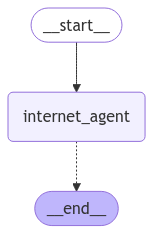

In [7]:
# Flow

# Initialize the workflow state graph
workflow = StateGraph(MessagesState)

# Add nodes to the workflow
workflow.add_node("internet_agent", internet_node)  
workflow.add_edge(START, "internet_agent")  # Connect the START node to the internet agent node

graph = workflow.compile()

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Failed to render the graph visualization: {e}")


In [8]:
# Main


query = "What are latest news related to USA right now, here is URL: https://timesofindia.indiatimes.com/"


inputs = {"messages": [("user", query)]}
print_stream(graph.stream(inputs, stream_mode="values"))

================================ Human Message =================================

What are latest news related to USA right now, here is URL: https://timesofindia.indiatimes.com/
================================ Human Message =================================
Name: internet_agent

Here are the latest news related to the USA:

1. **US State Department Suspends Passport Applications**: The US State Department has suspended passport applications that contain 'X' gender markers.

2. **Vivek Ramaswamy Fired**: Vivek Ramaswamy faced termination from DOGE due to an angry H-1B tweet and speculation about his Hindu faith.

3. **Trump Grants Pardons**: Donald Trump has granted pardons to pro-life demonstrators convicted under the FACE act.

4. **Children Missing School due to Weather**: Nearly 250 million children missed school last year because of extreme weather, according to UNICEF.

5. **US and Immigration Policies**: Ongoing discourse around reforming immigration policies in light of Trump'